<a href="https://colab.research.google.com/github/usmanqadeer1/AI-MLProjects/blob/master/Tensorflow_Specialization/CNN_Cat_vs_Dog_w_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-09-20 15:12:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   145MB/s    in 5.5s    

2020-09-20 15:12:40 (143 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))


12501
12501


In [4]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
MAIN_DIR = '/tmp/cats-v-dogs'
TRAINING_DIR = '/tmp/cats-v-dogs/training'
TESTING_DIR = '/tmp/cats-v-dogs/testing'
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

directories = [MAIN_DIR, TRAINING_DIR, TESTING_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR]
try:
    for d in directories:
        os.mkdir(d)
        print(d, ' created')
except OSError:
    print(d, ' failed or already created')
    pass

/tmp/cats-v-dogs  created
/tmp/cats-v-dogs/training  created
/tmp/cats-v-dogs/testing  created
/tmp/cats-v-dogs/training/cats/  created
/tmp/cats-v-dogs/testing/cats/  created
/tmp/cats-v-dogs/training/dogs/  created
/tmp/cats-v-dogs/testing/dogs/  created


In [5]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    
    files = os.listdir(SOURCE)
    valid_files = []
    
    for f in files:
        if os.path.getsize(SOURCE + f) > 0:
            valid_files.append(f)
        else:
            print(f, ' has zero file size so has been rejected')
            
    n_files = len(valid_files)
    split_point = int(SPLIT_SIZE * n_files)
    training_files = valid_files[:split_point]
    testing_files = valid_files[split_point:]
    
    for f in training_files:
        copyfile(SOURCE + f, TRAINING + f)
        
    for f in testing_files:
        copyfile(SOURCE + f, TESTING + f)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg  has zero file size so has been rejected
11702.jpg  has zero file size so has been rejected


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 36992)           

In [42]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   batch_size = 64)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(TESTING_DIR,
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   batch_size = 64)



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [43]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/15
240/352 [===================>..........] - ETA: 48s - loss: 0.6807 - acc: 0.5792

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 160s 456ms/step - loss: 0.6643 - acc: 0.6031 - val_loss: 0.5665 - val_acc: 0.7016
Epoch 2/15
352/352 [==============================] - 161s 458ms/step - loss: 0.5815 - acc: 0.6923 - val_loss: 0.4953 - val_acc: 0.7576
Epoch 3/15
352/352 [==============================] - 160s 456ms/step - loss: 0.5344 - acc: 0.7294 - val_loss: 0.4680 - val_acc: 0.7892
Epoch 4/15
352/352 [==============================] - 161s 457ms/step - loss: 0.4943 - acc: 0.7587 - val_loss: 0.4189 - val_acc: 0.8160
Epoch 5/15
352/352 [==============================] - 160s 456ms/step - loss: 0.4749 - acc: 0.7737 - val_loss: 0.3913 - val_acc: 0.8292
Epoch 6/15
352/352 [==============================] - 161s 459ms/step - loss: 0.4490 - acc: 0.7919 - val_loss: 0.4352 - val_acc: 0.8076
Epoch 7/15
352/352 [==============================] - 161s 457ms/step - loss: 0.4274 - acc: 0.8036 - val_loss: 0.3531 - val_acc: 0.8480
Epoch 8/15
352/352 [==============================] - 161s 

Text(0.5, 1.0, 'Training and validation loss')

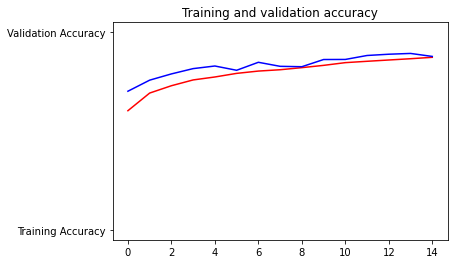

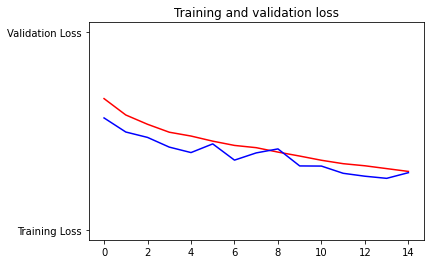

In [44]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

## Testing Transfer Learning

In [40]:
model = tf.keras.applications.VGG16(include_top=False, input_shape=(150, 150, 3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier layers
flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
class1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(class1)
# define new model
model = tf.keras.Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
 83/352 [======>.......................] - ETA: 2:02 - loss: 0.4820 - acc: 0.7771

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 173s 492ms/step - loss: 0.3473 - acc: 0.8451 - val_loss: 0.2345 - val_acc: 0.9016
Epoch 2/15
352/352 [==============================] - 173s 490ms/step - loss: 0.2816 - acc: 0.8751 - val_loss: 0.2000 - val_acc: 0.9232
Epoch 3/15
352/352 [==============================] - 172s 488ms/step - loss: 0.2701 - acc: 0.8854 - val_loss: 0.2044 - val_acc: 0.9188
Epoch 4/15
352/352 [==============================] - 171s 485ms/step - loss: 0.2605 - acc: 0.8855 - val_loss: 0.2133 - val_acc: 0.9092
Epoch 5/15
352/352 [==============================] - 172s 488ms/step - loss: 0.2552 - acc: 0.8899 - val_loss: 0.1791 - val_acc: 0.9228
Epoch 6/15
352/352 [==============================] - 171s 486ms/step - loss: 0.2430 - acc: 0.8953 - val_loss: 0.1802 - val_acc: 0.9200
Epoch 7/15
352/352 [==============================] - 171s 487ms/step - loss: 0.2372 - acc: 0.8980 - val_loss: 0.1806 - val_acc: 0.9236
Epoch 8/15
352/352 [==============================] - 171s 